In [ ]:
#PREPARE DATA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define the specific path within your Google Drive
specific_path = '/content/drive/Othercomputers/My Mac/google_drive'

# Change the current working directory to the specific path
os.chdir(specific_path)

# Verify the current directory
print("Current directory:", os.getcwd())

# List files in the specific directory
files = os.listdir()
print("Files in the specific directory:", files)

Current directory: /content/drive/Othercomputers/My Mac/google_drive
Files in the specific directory: ['SN001.pkl', 'SN003.pkl', 'SN004.pkl', 'SN007.pkl', 'SN009.pkl', 'SN010.pkl', 'SN025.pkl', 'SN027.pkl', 'vit-explain']


In [ ]:
import pickle

ds = []

for file_name in files:
    if file_name.endswith('.pkl'):

        with open(file_name, 'rb') as f:
            data = pickle.load(f)
            for elem in data:
              ds.append(elem)


In [ ]:
print(len(ds))
#ds = ds[:20000]
print(len(ds))

51201
51201


In [ ]:
####split up dataset into train test and val
from sklearn.model_selection import train_test_split

train_data, remaining_data = train_test_split(ds, test_size=0.3, random_state=42)

val_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 35840
Validation set size: 7680
Test set size: 7681


In [ ]:
import torch

def collate_fn(batch):
  #process and stack images. The datatype is: torch.float32
  pixel_values = torch.stack([processor(images=x['img'], return_tensors='pt').pixel_values.squeeze() for x in batch])

  #process and stack labels
  labels = torch.tensor([x['labels'] for x in batch])

  return {
      'pixel_values': pixel_values,
      'labels': labels
  }

In [ ]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
#CREATE MODEL

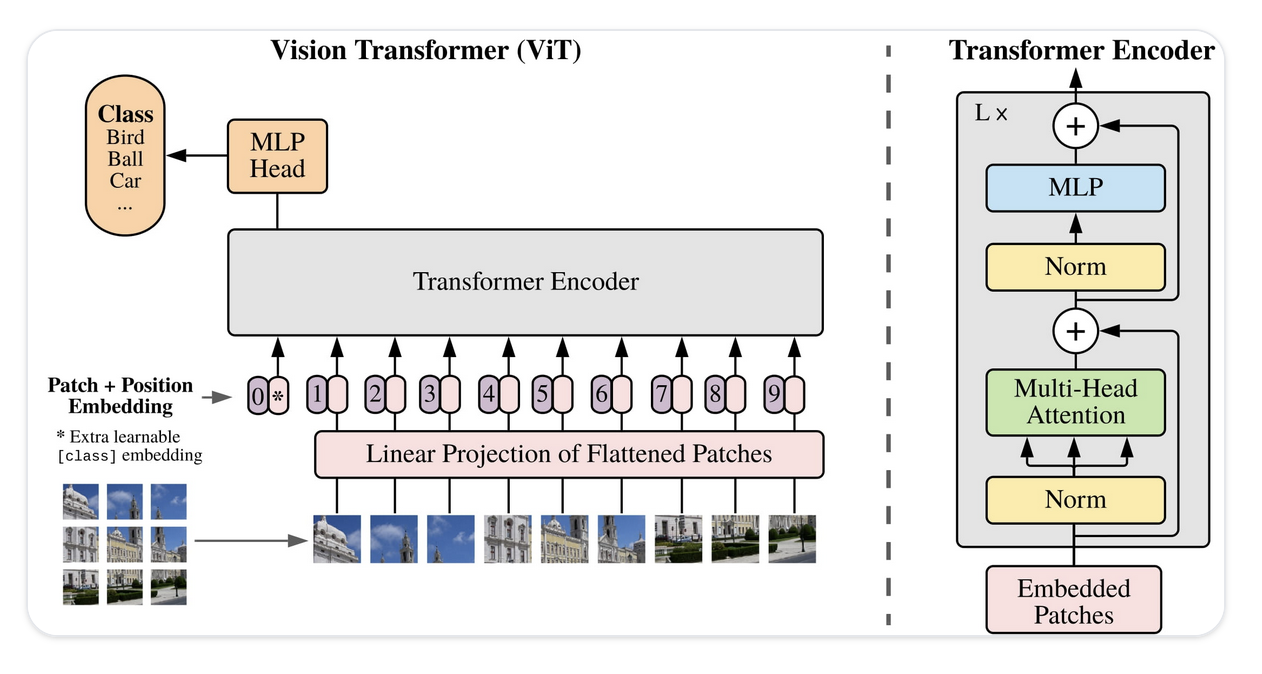

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTModel

class ViTForMultiTaskClassification(nn.Module):
    def __init__(self, model_name_or_path, num_tasks, num_classes):
        super(ViTForMultiTaskClassification, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name_or_path)
        self.classifiers = nn.ModuleList([nn.Linear(self.vit.config.hidden_size, num_classes) for _ in range(num_tasks)])

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values)
        #access last hidden state of shape: [batch_size x seq_len x hidden_size] ->[b , 197, 768]
        #only keep [CLS token] ... reduce to [batch_size x hidden_size]
        hidden_states = outputs.last_hidden_state[:, 0, :]
        logits_list = [classifier(hidden_states) for classifier in self.classifiers]
        return logits_list


In [ ]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'

num_tasks = 12
num_classes = 6

processor = ViTImageProcessor.from_pretrained(model_name_or_path)
model = ViTForMultiTaskClassification(model_name_or_path, num_tasks, num_classes)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
#HYPER PARAMS
import torch.nn as nn
import torch.optim as optim

# Define loss functions for each task
loss_function = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 25
patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

In [ ]:
#####TRAINING

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

ViTForMultiTaskClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(i

In [ ]:
train_losses = []
val_losses = []

In [ ]:
!nvidia-smi

Mon Jun 17 15:34:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              29W /  70W |    923MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import matplotlib.pyplot as plt

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        #labels.shape -> [batch_size x num_tasks]

        # Forward pass, returns list of torch.tensor. Output tensor has shape [batch_size x num_classes]
        logits = model(pixel_values)

        total_loss = 0
        #add the loss calculated for every classification_task separately and add them up
        for i in range(num_tasks):
            task_logits = logits[i] #iterate over each logit tensor of all classification layers
            task_labels = labels[:, i] #iterate over labels and return labels related to the task
            loss = loss_function(task_logits, task_labels)
            total_loss += loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()

    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(pixel_values)

            # Calculate loss for each task
            total_loss = 0
            for i in range(num_tasks):
                task_logits = logits[i]
                task_labels = labels[:, i]
                loss = loss_function(task_logits, task_labels)
                total_loss += loss

            val_loss += total_loss.item()

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    #early stopping check:
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      epochs_no_improve = 0
    else:
      epochs_no_improve += 1

    if epochs_no_improve >= patience:
      print('Early stopping since there is no improvement the last 3 epochs')
      break




# Plotting the training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1, Train Loss: 11.0113, Validation Loss: 7.8455
Epoch 2, Train Loss: 6.4679, Validation Loss: 5.5479


In [ ]:
print(train_losses)
print(val_losses)

In [ ]:
nums = 20

plt.plot(range(1, nums + 1), train_losses, label='Training Loss')
plt.plot(range(1, nums + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/model2.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
#########TEST MODEL

In [ ]:
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model(model, test_loader, num_tasks):
    model.eval()  # Set the model to evaluation mode
    all_preds = [[] for _ in range(num_tasks)]
    all_labels = [[] for _ in range(num_tasks)]

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(pixel_values)

            for i in range(num_tasks):
                task_logits = logits[i]
                _, preds = torch.max(task_logits, 1)  # Get the predicted class
                all_preds[i].extend(preds.cpu().numpy())
                all_labels[i].extend(labels[:, i].cpu().numpy())

    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for i in range(num_tasks):
        accuracy = accuracy_score(all_labels[i], all_preds[i])
        accuracies.append(accuracy)
        print(f"Accuracy for task {i+1}: {accuracy:.4f}")

        precision = precision_score(all_labels[i], all_preds[i], average='weighted')
        precisions.append(precision)
        print(f"Precision for task {i+1}: {precision:.4f}")

        recall = recall_score(all_labels[i], all_preds[i], average='weighted')
        recalls.append(recall)
        print(f"Recall for task {i+1}: {recall:.4f}")

        f1 = f1_score(all_labels[i], all_preds[i], average='weighted')
        f1s.append(f1)
        print(f"F1 for task {i+1}: {f1:.4f}")
        print('--- --- --- --- --- --- --- --- --- ---')

    print('Overall Metrics:')
    overall_accuracy = sum(accuracies) / num_tasks
    return_accuracies = {"acc": accuracies, "overall_acc": overall_accuracy}
    print(f"Overall accuracy: {overall_accuracy:.4f}")

    overall_precision = sum(precisions) / num_tasks
    return_precisions = {"pre": precisions, "overall_pre": overall_precision}
    print(f"Overall precision: {overall_precision:.4f}")

    overall_recall = sum(recalls) / num_tasks
    return_recalls = {"rec": recalls, "overall_rec": overall_recall}
    print(f"Overall recall: {overall_recall:.4f}")

    overall_f1 = sum(f1s) / num_tasks
    return_f1s = {"rec": f1s, "overall_rec": overall_f1}
    print(f"Overall F1: {overall_f1:.4f}")



    return [return_accuracies, return_precisions, return_recalls, return_f1s]


results = test_model(model, test_loader, num_tasks)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model(model, test_loader, num_tasks):
    model.eval()  # Set the model to evaluation mode
    all_preds = [[] for _ in range(num_tasks)]
    all_labels = [[] for _ in range(num_tasks)]

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(pixel_values)

            for i in range(num_tasks):
                task_logits = logits[i]
                _, preds = torch.max(task_logits, 1)  # Get the predicted class
                all_preds[i].extend(preds.cpu().numpy())
                all_labels[i].extend(labels[:, i].cpu().numpy())

    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for i in range(num_tasks):
        accuracy = accuracy_score(all_labels[i], all_preds[i])
        accuracies.append(accuracy)
        print(f"Accuracy for task {i+1}: {accuracy:.4f}")

        precision = precision_score(all_labels[i], all_preds[i], average='weighted')
        precisions.append(precision)
        print(f"Precision for task {i+1}: {precision:.4f}")

        recall = recall_score(all_labels[i], all_preds[i], average='weighted')
        recalls.append(recall)
        print(f"Recall for task {i+1}: {recall:.4f}")

        f1 = f1_score(all_labels[i], all_preds[i], average='weighted')
        f1s.append(f1)
        print(f"F1 for task {i+1}: {f1:.4f}")
        print('--- --- --- --- --- --- --- --- --- ---')

    print('Overall Metrics:')
    overall_accuracy = sum(accuracies) / num_tasks
    return_accuracies = {"acc": accuracies, "overall_acc": overall_accuracy}
    print(f"Overall accuracy: {overall_accuracy:.4f}")

    overall_precision = sum(precisions) / num_tasks
    return_precisions = {"pre": precisions, "overall_pre": overall_precision}
    print(f"Overall precision: {overall_precision:.4f}")

    overall_recall = sum(recalls) / num_tasks
    return_recalls = {"rec": recalls, "overall_rec": overall_recall}
    print(f"Overall recall: {overall_recall:.4f}")

    overall_f1 = sum(f1s) / num_tasks
    return_f1s = {"rec": f1s, "overall_rec": overall_f1}
    print(f"Overall F1: {overall_f1:.4f}")



    return [return_accuracies, return_precisions, return_recalls, return_f1s]


results = test_model(model, test_loader, num_tasks)
